# __Builidng a Simple Regression model__

## Requirements for the notebook
!pip install yellowbrick rdkit PyTDC lightgbm scikit-learn

In [39]:
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from yellowbrick.regressor import ResidualsPlot, prediction_error
from tdc.single_pred import ADME # Using the Therapuetic Data Commons

# Setting default paramters 
sns.set_context('talk') # Setting the sclaing of plotting elements
tqdm.pandas() # Enabling progress bar

### __Readin input data from PyTDC ADME__

The data is the from the article ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure "https://pubs.acs.org/doi/10.1021/ci034243x".

The data is supplied by Therapuetic Data Commons

In [6]:
# Setting query to get the data
data = ADME(name= 'Solubility_AqSolDB') # Using the Therapuetic Data Commons

# Downloading the data
sol_df = data.get_data()

# rename the columns
sol_df.columns = ["Name", "SMILES", "LogS"]

Found local copy...
Loading...
Done!


In [13]:
# Setting up property calculations by listing the properties 
# that can be calculated and setting it up as a variable

property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_calculator = rdMolDescriptors.Properties(property_names)

def smiles2prop(smi="SMILES", mol="mol"):
    """
    Converts a SMILES string to a molecule and calculates its properties.

    Parameters:
    smi (str): The SMILES string of the molecule.
    mol (str): The molecule object.

    Returns:
    numpy.ndarray: An array containing the calculated properties of the molecule.
    """
    # Make rdkit molecules from smiles
    mol = Chem.MolFromSmiles(smi)
    
    # Setting prop variable to nnothing
    props = None

    # Making a if statement to calculate the properties
    if mol:
        # Delete hydrogens
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        # Calculate the properties
        props = np.array(property_calculator.ComputeProperties(mol))

    #return the claculated properties
    return props

In [22]:
# Calculate the properies for each molecule and add to the dataframe
sol_df["properties"] = sol_df["SMILES"].progress_apply(smiles2prop)

# Split the properties into indiviudal columns
sol_df[property_names] = sol_df["properties"].tolist()

# drop the properties column
sol_df.drop(columns=["properties"], inplace=True)

  0%|          | 0/9982 [00:00<?, ?it/s]

[11:49:23] WARNING: not removing hydrogen atom without neighbors
[11:49:23] WARNING: not removing hydrogen atom without neighbors
[11:49:23] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:24] WARNING: not removing hydrogen atom without neighbors
[11:49:25] WARNING: not removing hydrogen atom without neighbors
[11:49:25] WARNING: not removing hydrogen atom without neighbors
[11:49:25] WARNING: not removing hydrogen atom without neighbors
[11:49:25] WARNING: not r

In [23]:
sol_df.shape

(9982, 46)

In [24]:
# Splitting data
# setting X and y to the data frames of the properties and the logS values
X = sol_df[property_names]
y = sol_df["LogS"]

# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# Create, train and predict using the lgbm regressor
lgbm = LGBMRegressor()

# training the model
lgbm.fit(X_train, y_train)

# predicting
y_pred = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6081
[LightGBM] [Info] Number of data points in the train set: 7985, number of used features: 43
[LightGBM] [Info] Start training from score -2.884100


[Text(0.5, 0, 'True LogS'), Text(0, 0.5, 'Predicted LogS')]

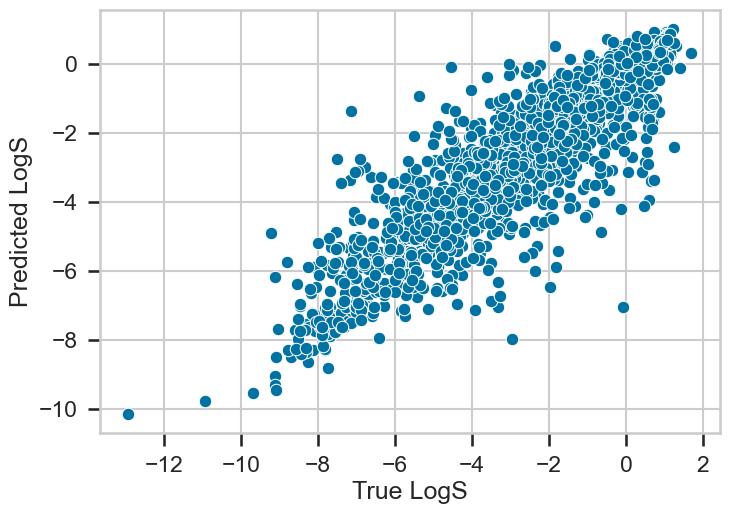

In [28]:
# plot results
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel="True LogS", ylabel="Predicted LogS")


### Make the same plot with Seaboen regplot
The plot also adds a line for the perfect model

[Text(0, 0.5, 'Predicted LogS')]

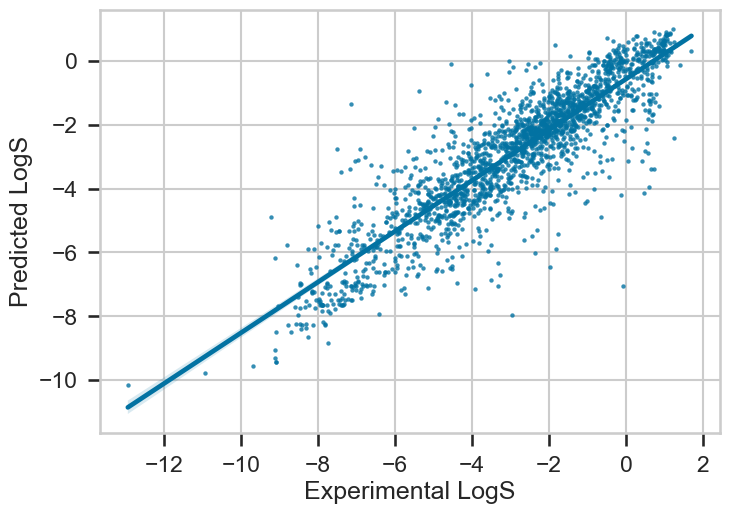

In [30]:
ax = sns.regplot(x=y_test,y=y_pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

In [34]:
#Calculating accuarcy metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R2: {r2:.4f}", f"RMSE: {rmse:.4f}")

R2: 0.7827 RMSE: 1.0856


### Plotting feature importance obtained from lightGBM regressor.

This is vlauable information as it can assist the researcher to determine which features to focus on when building larger and more complicated models

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

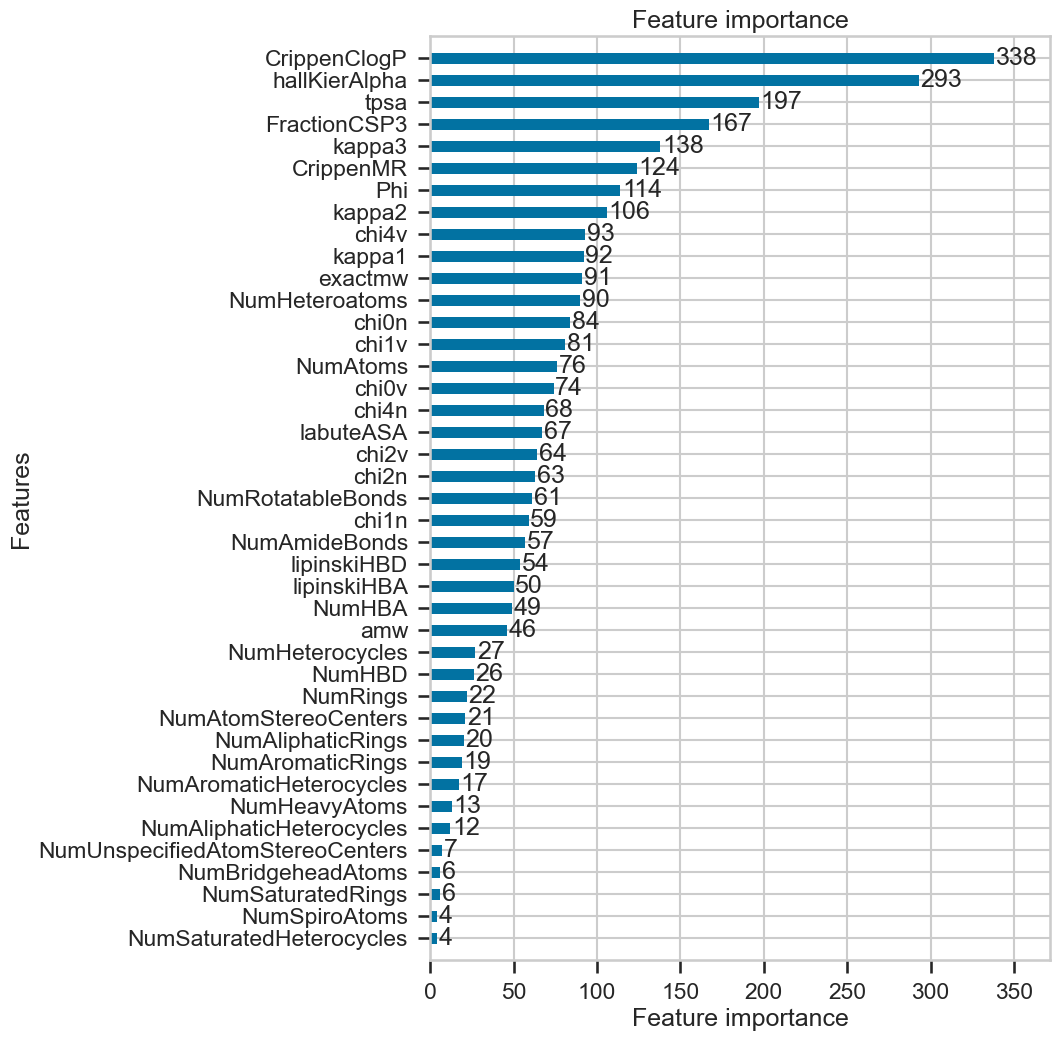

In [38]:
# Plotting feature importance in the model
plot_importance(lgbm,figsize=(8,12),height=0.5)

### Using Yellowbricks library to generate useful diagnostic plots for ML models

Link: [Yellowbick](https://www.scikit-yb.org/en/latest/index.html)

## The Yellowbrick library and LightGBM can be used for model sleection. 

__Model selection workflow includes:__

1. selecting and/or engineering the smallest and most predictive feature set ( Yellowbrick and feature importance)

2. Choosing a set of algorithms from a model family (Cross validation and p-value metrics)

3. Tuning the algorithm hyperparameters to optimize performance.(GridSearchCV,etc)

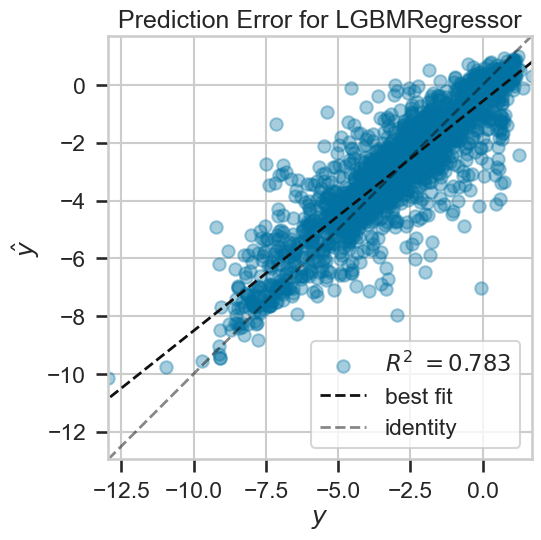

In [40]:
YB_Visulizer = prediction_error(lgbm, 
                                X_train, 
                                y_train, 
                                X_test, 
                                y_test, 
                                alpha=0.35 # The opacity on the graph
                                )

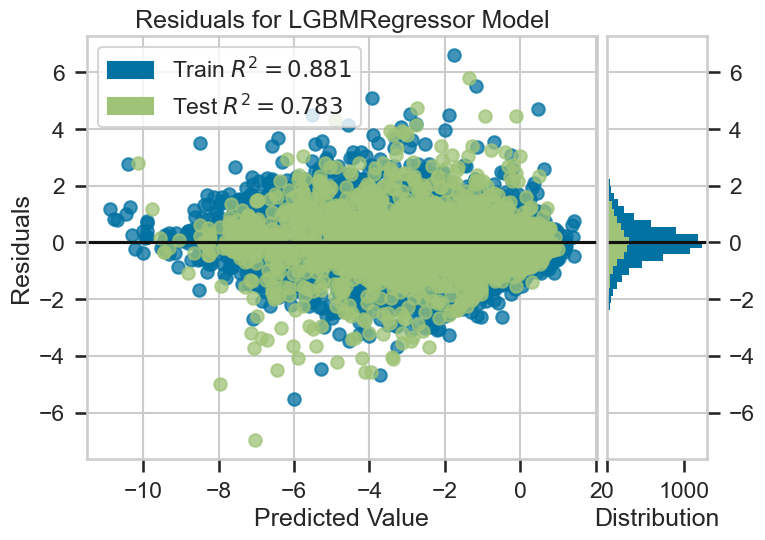

<Axes: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [41]:
# Visualizing Residual plot
RP_visualizer = ResidualsPlot(lgbm)

# Train the model
RP_visualizer.fit(X_train, y_train)

# Predict and evaluate
RP_visualizer.score(X_test, y_test)

#Show plot
RP_visualizer.show()


In [43]:
# Running cross-validation
r2_scores = []

for i in tqdm(range(0,10)):
    # splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Create regressor
    lgbm = LGBMRegressor()
    # train the model
    lgbm.fit(X_train, y_train)
    # predict
    y_pred = lgbm.predict(X_test)
    # Evaluating the model in current cycle
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)



  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6089
[LightGBM] [Info] Number of data points in the train set: 7985, number of used features: 43
[LightGBM] [Info] Start training from score -2.881625
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6085
[LightGBM] [Info] Number of data points in the train set: 7985, number of used features: 43
[LightGBM] [Info] Start training from score -2.883267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6089
[LightGBM] [Info] Number of data points in the train set

[(0.0, 1.0)]

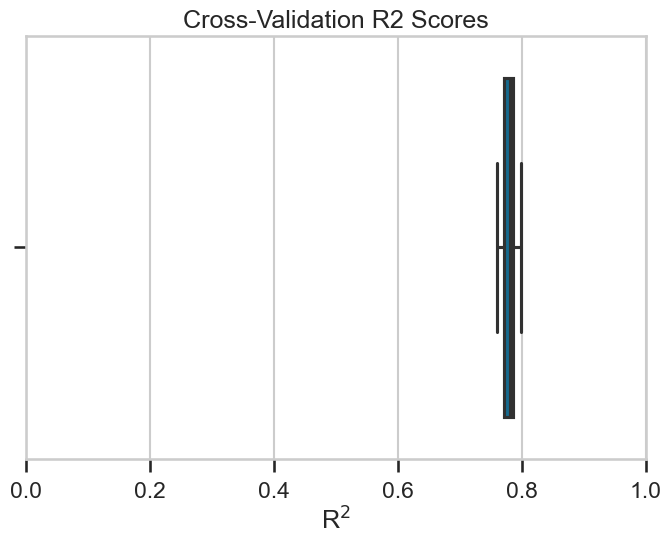

In [45]:
# plot results
ax = sns.boxplot(x=r2_scores)
ax.set(xlabel="R$^2$")
ax.set(title="Cross-Validation R2 Scores")
ax.set(xlim=(0,1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6099
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 43
[LightGBM] [Info] Start training from score -2.853990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6057
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 43
[LightGBM] [Info] Start training from score -2.789364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6092
[LightGBM] [Info] Number of data points in the train set

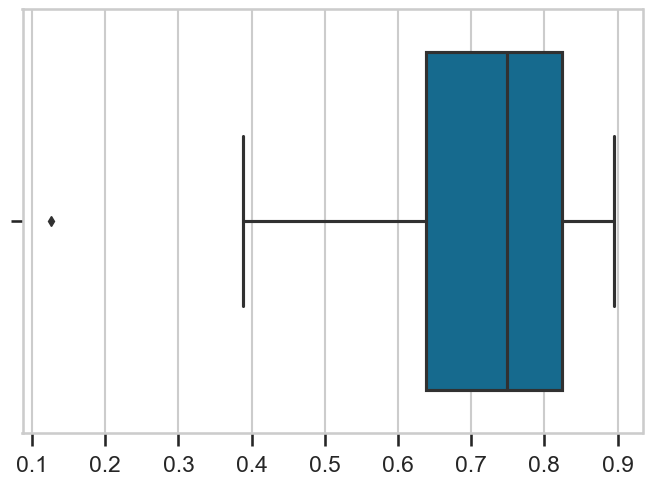

In [76]:
from sklearn.model_selection import cross_val_score
r2_scores = cross_val_score(lgbm, X, y, cv=10)  
ax = sns.boxplot(x=r2_scores)

In [77]:
print(f"{r2_scores.mean():.2f} accuracy with a standard deviation of {r2_scores.std():.2f}")

0.67 accuracy with a standard deviation of 0.23


In [81]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
scores = {
    'r2': make_scorer(r2_score),
    'rmse': make_scorer(mean_squared_error, squared=False)
}
y_pred = cross_validate(lgbm, X, y, cv=10, scoring=scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6099
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 43
[LightGBM] [Info] Start training from score -2.853990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6057
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 43
[LightGBM] [Info] Start training from score -2.789364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

In [90]:
rmse = y_pred.get('test_rmse')
r2 = y_pred.get('test_r2')
time = y_pred.get('fit_time')
score_time = y_pred.get('score_time')
print(f"RMSE: {rmse.mean():.3f} +- {rmse.std():.3f}")
print(f"R2: {r2.mean():.3f} +- {r2.std():.3f}")
print(f"Fit time: {time.mean():.3f} +- {time.std():.3f}")
print(f"Score time: {score_time.mean():.3f} +- {score_time.std():.3f}")

RMSE: 1.135 +- 0.337
R2: 0.667 +- 0.227
Fit time: 0.364 +- 0.108
Score time: 0.006 +- 0.001


dict_keys(['fit_time', 'score_time', 'test_r2', 'test_rmse'])